#### Imports

In [1]:
#Adding working directory to python path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#Import function to laod and process dataset
from utils.data_processing import ObjectSelector, preprocess_dataset
import scipy.stats as stats

#Standard import
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

#### Parameters

In [3]:
FILE = 'MRec40'  # MRec40, ZRec50 or ZRec50_Mini
DATASET_PATH = f'../data/Objects Task DL Project/{FILE}.neo.mat' 
BINNED_DATASET_FOLDER = f'../data/Objects Task DL Project/binned'
BINNING_TIME = 0.04
PLOTS_FOLDER = '../plots/dataset'
EPOCH = 'all'

### Plotting functions

In [4]:
def display_dataset_distribution(unique_class, n_repetition, class_name='classes', labels=None, save=True):
    fig, ax = plt.subplots(figsize = (18 - (36-len(unique_class))*8/31, 5))
    x = list(range(len(unique_class)))
    rects = ax.bar(x, n_repetition, alpha=0.7)
    ax.set_xticks(x)
    if labels is None:
        ax.set_xticklabels(unique_class)
    else:
        ax.set_xticklabels(labels)

    y_max = max(n_repetition)*1.15
    ax.set_ylim([0, y_max])
    ax.set_xlim(x[0]-.55, x[-1]+.55)
    ax.axhline(y=n_repetition.mean(), color='midnightblue', linestyle='-', label='mean', lw=1.5)
    ax.axhspan(n_repetition.mean()-n_repetition.std(), n_repetition.mean()+n_repetition.std(), alpha=0.3, color='orange', label='std')
    ax.set_xlabel(class_name[:-1], fontsize=12)
    ax.set_ylabel('repetitions', fontsize=12)
    ax.set_title(f'Distribution of {class_name} examples in the dataset', fontsize=14)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
    plt.legend()
    plt.tight_layout()
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{class_name.replace(" ", "_")}_distribution.png')
    plt.show()

### Loading dataset

In [5]:
def load_dataset(file_path, bin_length=0.04):
    try:
        binned_trials = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_binned_trials.npy')
        targets = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_objs.npy')
        trial_states = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_states.npy')
        durations = np.load(f'{BINNED_DATASET_FOLDER}/{FILE}_durations.npy')
        print(f'{len(durations[:,0])} good trials, with average duration: {durations[:,0].mean()}s and std: {durations[:,0].std()}s')
        average_bins = round(durations[:,0].mean() / bin_length)
        print(f'Number of bins having average duration {bin_length}s: {average_bins}')

    except IOError:
        from neo.io.neomatlabio import NeoMatlabIO
        from elephant.conversion import BinnedSpikeTrain
        import quantities
        from bisect import bisect

        r = NeoMatlabIO(filename=file_path)
        blk = r.read_block()

        spikes_list = []
        events = []
        targets = []
        durations = []
        discarded = []
        for i, seg in enumerate(blk.segments):  # segments are the individual trials
            # Every run performed by the monkey is checked, and if it is not correct it is ignored
            if seg.annotations['correct'] == 0:
                discarded.append(i)
                continue

            spikes_list.append(seg.spiketrains)  # list of trials in spikelists fashion        
            events.append(seg.events[0])  # list of events associated to each trial
            targets.append(seg.annotations['obj'])   # list of objects associated to each trial

            times = np.array([(spiketrain.t_start, spiketrain.t_stop) for spiketrain in seg.spiketrains])
            t_start = max(events[-1][0], times[:,0].min()*quantities.s)
            t_stop = min(events[-1][-1], times[:,1].max()*quantities.s)

            durations.append((t_stop-t_start, t_start, t_stop))  # list of duration of each trial

        n_seg = i + 1
        kept = n_seg - len(discarded)
        print(f'The dataset contained {n_seg} trials, of which {len(discarded)} were aborted due to monkey mistake')
        durations = np.array(durations)
        mu_t = durations[:,0].mean()
        sigma_t = durations[:,0].std()

        assert kept == len(durations[:,0])
        print(f'{len(durations[:,0])} good trials, with average duration: {mu_t}s and std: {sigma_t}s')
        average_bins = round(mu_t / bin_length)
        print(f'Number of bins having average duration {bin_length}s: {average_bins}')

        binned_trials = []
        trial_states = []
        for j in range(kept):
            binned_trials.append(
                BinnedSpikeTrain(spikes_list[j], 
                                 n_bins=average_bins, 
                                 t_start=durations[j,1]*quantities.s,
                                 t_stop=durations[j,2]*quantities.s
                                ).to_array()
            )
            evt = list(events[j].times)
            labels = events[j].labels
            step = durations[j,0]/average_bins*quantities.s
            trial_states.append(
                [labels[bisect(evt, t) - 1].strip() for t in np.arange(evt[0], evt[-1]+0.001*quantities.s, step)[1:]] 
            )
            assert binned_trials[-1].shape[1] == len(trial_states[-1])
        binned_trials = np.array(binned_trials)
        targets = np.array(targets)
        trial_states = np.array(trial_states)
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_binned_trials.npy', binned_trials)
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_objs.npy', targets)
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_states.npy', trial_states)    
        np.save(f'{BINNED_DATASET_FOLDER}/{FILE}_durations.npy', durations) 
        
    return binned_trials, targets, trial_states, durations[:,0]

In [6]:
# Load dataset
all_measurements, all_objects, all_states, duration = load_dataset(DATASET_PATH, BINNING_TIME)

628 good trials, with average duration: 5.5703993811728845s and std: 0.7236103431406848s
Number of bins having average duration 0.04s: 139


In [7]:
all_measurements.shape

(628, 552, 139)

duration mean: 5.5703993811728845s ;  std: 0.7236103431406848 ;  n_bins: 139


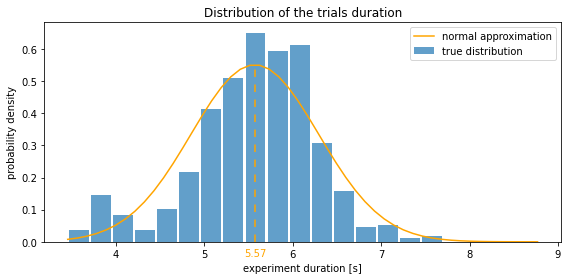

In [8]:
mu = duration.mean()
sigma = duration.std()
x = np.linspace(min(duration), max(duration))
normal = stats.norm.pdf(x, mu, sigma)

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(duration, bins=np.arange(x[0], x[-1], .25), density=True, alpha=0.7, label='true distribution', rwidth=0.9, align='mid')
ax.plot(x, normal, color='orange', label='normal approximation')
ax.set_xlabel('experiment duration [s]')
ax.set_ylabel('probability density')
ax.set_title('Distribution of the trials duration')

xlim = ax.get_ylim()[1]
ax.axvline(x=mu, ymin=0, ymax=1/ax.get_ylim()[1]*max(normal), color='orange', ls='--', dashes=(5, 5))
ax.text(mu-.12, -.045, round(mu,2), color='orange', fontsize=10)
plt.legend()
plt.tight_layout()
fig.savefig(f'{PLOTS_FOLDER}/duration_distribution.png')
print(f'duration mean: {mu}s ;  std: {sigma} ;  n_bins: {round(mu/0.04)}')

In [9]:
# Studio la distribuzione degli oggetti
unique_obj, old_n_repetition = np.unique(all_objects, return_counts=True, axis=0)
# display_dataset_distribution(unique_obj[8:-24], n_repetition[8:-24], 'objects', save=False)
# display_dataset_distribution(unique_obj[-24:-6], n_repetition[-24:-6], 'objects2', save=False)
# print(n_repetition.mean(), n_repetition.std(), n_repetition.std()/n_repetition.mean())

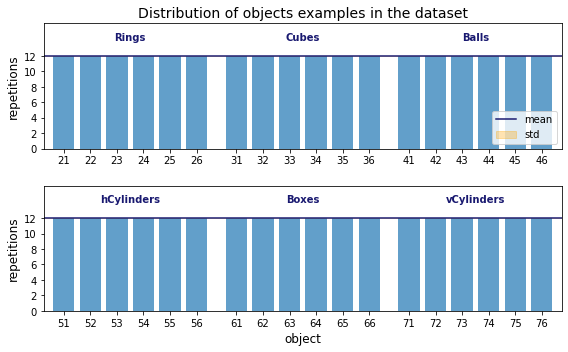

In [18]:
unique_class = unique_obj[8:-6]
n_repetition = old_n_repetition[8:-6]
class_name = 'objects'
labels = None
save = False
gs = gridspec.GridSpec(nrows=2, ncols=1)

fig = plt.figure(figsize = (8, 5))

ax1 = fig.add_subplot(gs[0,:])
x = list(range(len(unique_class[:18])))
for i in range(len(x)):
    x[i] += 0.5*(i//6)

rects = ax1.bar(x, n_repetition[:18], alpha=0.7)
ax1.set_xticks(x)
ax1.set_xticklabels(unique_class[:18])
y_max = max(n_repetition)*1.35
ax1.set_yticks(list(range(max(n_repetition)+1))[::2])
#ax1.set_yticklabels(unique_class[:18])
ax1.set_ylim([0, y_max])
ax1.set_xlim(x[0]-.75, x[-1]+.75)
ax1.axhline(y=n_repetition.mean(), color='midnightblue', linestyle='-', label='mean', lw=1.5)
ax1.axhspan(n_repetition.mean()-n_repetition.std(), n_repetition.mean()+n_repetition.std(), alpha=0.3, color='orange', label='std')
#ax1.set_xlabel('class', fontsize=12)
ax1.set_ylabel('repetitions', fontsize=12)
ax1.set_title(f'Distribution of {class_name} examples in the dataset', fontsize=14)
# for rect in rects:
#     height = rect.get_height()
#     ax1.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#             '%d' % int(height),
#             ha='center', va='bottom')
ax1.text(x[2]+0.5, y_max-2.15, 'Rings', ha='center', color='midnightblue', fontsize=10, weight='bold')
ax1.text(x[8]+0.5, y_max-2.15, 'Cubes', ha='center', color='midnightblue', fontsize=10, weight='bold')
ax1.text(x[14]+0.5, y_max-2.15, 'Balls', ha='center', color='midnightblue', fontsize=10, weight='bold')

    
ax2 = fig.add_subplot(gs[1,:])
#x = np.arange(len(unique_class[18:]))
rects = ax2.bar(x, n_repetition[18:], alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(unique_class[18:])
ax2.set_yticks(list(range(max(n_repetition)+1))[::2])
ax2.set_ylim([0, y_max])
ax2.set_xlim(x[0]-.75, x[-1]+.75)
ax2.axhline(y=n_repetition.mean(), color='midnightblue', linestyle='-', label='mean', lw=1.5)
ax2.axhspan(n_repetition.mean()-n_repetition.std(), n_repetition.mean()+n_repetition.std(), alpha=0.3, color='orange', label='std')
ax2.set_xlabel(class_name[:-1], labelpad=4, fontsize=12)
ax2.set_ylabel('repetitions', fontsize=12)
# for rect in rects:
#     height = rect.get_height()
#     ax2.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#             '%d' % int(height),
#             ha='center', va='bottom')
ax2.text(x[2]+0.5, y_max-2.15, 'hCylinders', ha='center', color='midnightblue', fontsize=10, weight='bold')
ax2.text(x[8]+0.5, y_max-2.15, 'Boxes', ha='center', color='midnightblue', fontsize=10, weight='bold')
ax2.text(x[14]+0.5, y_max-2.15, 'vCylinders', ha='center', color='midnightblue', fontsize=10, weight='bold')
    
ax1.legend(loc='lower right')
plt.tight_layout(h_pad=2)

fig.savefig(f'{PLOTS_FOLDER}/{class_name.replace(" ", "_")}_distribution.png')
plt.show()

In [16]:
from sklearn.preprocessing import LabelEncoder
selector = ObjectSelector()
new_classes = selector.get_non_special(group_labels=True)
label_encoder = LabelEncoder()
X, Y = preprocess_dataset(all_measurements, all_objects, labelled_classes=new_classes, one_hot_encoder=label_encoder)

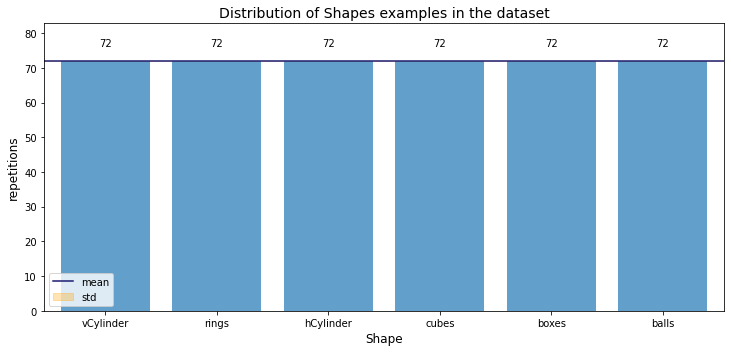

72.0 0.0 0.0


In [17]:
unique_obj, n_repetition = np.unique(Y, return_counts=True, axis=0)

display_dataset_distribution(label_encoder.inverse_transform(unique_obj.argmax(axis=1)), n_repetition, 'Shapes')
print(n_repetition.mean(), n_repetition.std(), n_repetition.std()/n_repetition.mean())

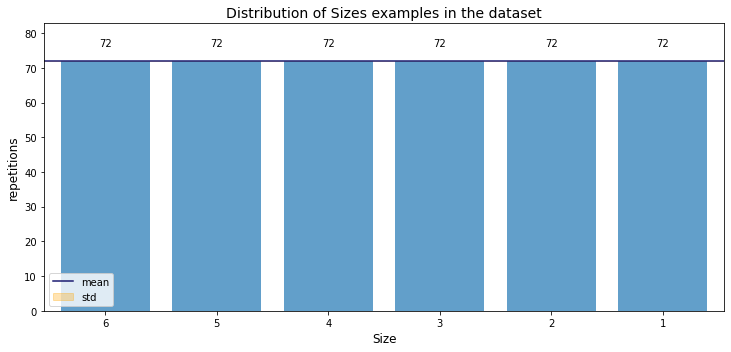

72.0 0.0 0.0


In [19]:
new_classes = [
    (['21', '31', '41', '51', '61', '71'], '1'),
    (['22', '32', '42', '52', '62', '72'], '2'),
    (['23', '33', '43', '53', '63', '73'], '3'),
    (['24', '34', '44', '54', '64', '74'], '4'),
    (['25', '35', '45', '55', '65', '75'], '5'),
    (['26', '36', '46', '56', '66', '76'], '6')
]
label_encoder = LabelEncoder()
X, Y = preprocess_dataset(all_measurements, all_objects, labelled_classes=new_classes, one_hot_encoder=label_encoder)
unique_obj, n_repetition = np.unique(Y, return_counts=True, axis=0)
display_dataset_distribution(label_encoder.inverse_transform(unique_obj.argmax(axis=1)), n_repetition, 'Sizes')
print(n_repetition.mean(), n_repetition.std(), n_repetition.std()/n_repetition.mean())

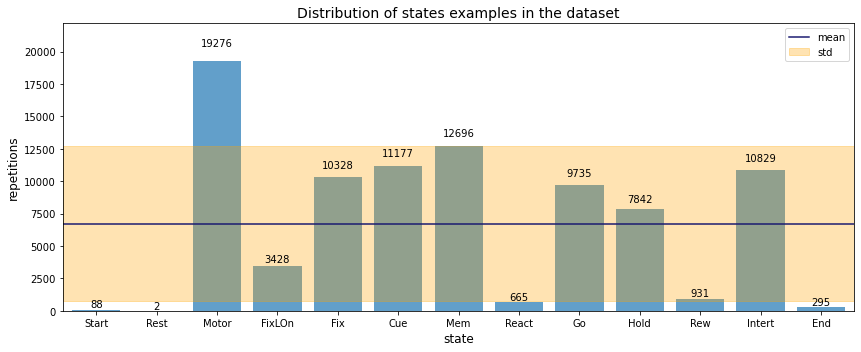

In [20]:
# Studio la distribuzione degli states
unique_states, n_repetition = np.unique(all_states.flatten(), return_counts=True, axis=0)
unique_states = np.array([x.strip() for x in unique_states])

# Reordering the labels to match the chronological order of phases instead of the alphabetical one
states_order = []
ordered_states = ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix', 'Cue', 'Mem', 'React', 'Go', 'Hold', 'Rew', 'Intert', 'End']
for ep in ordered_states:
    states_order.append(list(unique_states).index(ep))

display_dataset_distribution(unique_states[states_order], n_repetition[states_order], 'states', save=False)

In [28]:
tot_activations = []
for rec in all_measurements[:5,:,:]:
    tot_activations.append(rec.sum(axis=0))
tot_activations = np.array(tot_activations)

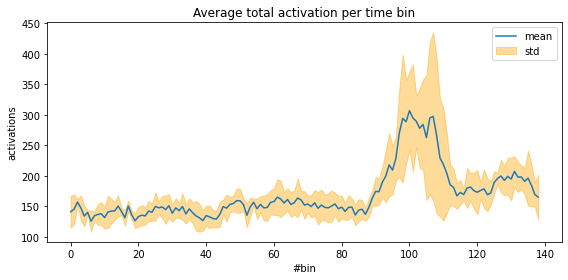

169.4043165467626 27.551337109586516


In [29]:
mean_activations = tot_activations.mean(axis=0)
std_activations = tot_activations.std(axis=0)

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('Average total activation per time bin')
ax.plot(mean_activations, label='mean')
ax.fill_between(list(range(len(mean_activations))), np.subtract(mean_activations, std_activations), np.add(mean_activations, std_activations), alpha=.4, color='orange', label='std')
ax.set_xlabel('#bin')
ax.set_ylabel('activations')
ax.legend()
plt.tight_layout()
fig.savefig(f'{PLOTS_FOLDER}/dataset_variance.png')
plt.show()

print(mean_activations.mean(), std_activations.mean())